## Traffic Analysis Development

1. First, create a new file `traffic_analysis.ipynb` and add these imports:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 2. Add data generation function:


In [2]:
def create_traffic_data(num_samples=5000):
    np.random.seed(42)
    
    # Generate base features
    data = {
        'time_of_day': np.random.randint(0, 24, num_samples),
        'day_of_week': np.random.randint(1, 8, num_samples),
        'vehicle_count': np.clip(np.random.normal(300, 100, num_samples), 0, 1000).astype(int),
        'weather_condition': np.random.randint(1, 5, num_samples),
        'road_type': np.random.randint(1, 5, num_samples),
        'special_event': np.random.choice([0, 1], num_samples, p=[0.9, 0.1]),
        'road_work': np.random.choice([0, 1], num_samples, p=[0.85, 0.15]),
        'accident_nearby': np.random.choice([0, 1], num_samples, p=[0.95, 0.05])
    }
    
    df = pd.DataFrame(data)
    
    # Calculate congestion
    congestion = np.zeros(num_samples)
    
    # Add patterns
    peak_hours = ((df['time_of_day'] >= 7) & (df['time_of_day'] <= 9) | 
                 (df['time_of_day'] >= 16) & (df['time_of_day'] <= 18))
    weekdays = (df['day_of_week'] >= 1) & (df['day_of_week'] <= 5)
    
    congestion += 0.3 * peak_hours
    congestion += 0.2 * weekdays
    congestion += 0.3 * (df['vehicle_count'] / 1000)
    
    # Add impacts
    weather_impact = {1: 0, 2: 0.15, 3: 0.3, 4: 0.2}
    for weather, impact in weather_impact.items():
        congestion += impact * (df['weather_condition'] == weather)
    
    road_impact = {1: 0.1, 2: 0.2, 3: 0.15, 4: 0.25}
    for road, impact in road_impact.items():
        congestion += impact * (df['road_type'] == road)
    
    congestion += 0.25 * df['special_event']
    congestion += 0.2 * df['road_work']
    congestion += 0.3 * df['accident_nearby']
    
    df['congestion_level'] = np.clip(congestion + np.random.normal(0, 0.05, num_samples), 0, 1)
    return df

# Generate data
df = create_traffic_data()
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5000, 9)


,time_of_day,day_of_week,vehicle_count,weather_condition,road_type,special_event,road_work,accident_nearby,congestion_level
0,6,2,333,2,1,0,0,0,0.545591
1,19,2,367,3,1,0,0,0,0.754004
2,14,2,270,2,1,1,0,0,0.767918
3,10,4,249,4,1,0,0,0,0.583087
4,7,3,569,3,3,0,0,0,1.000000


## 3. Add visualization:


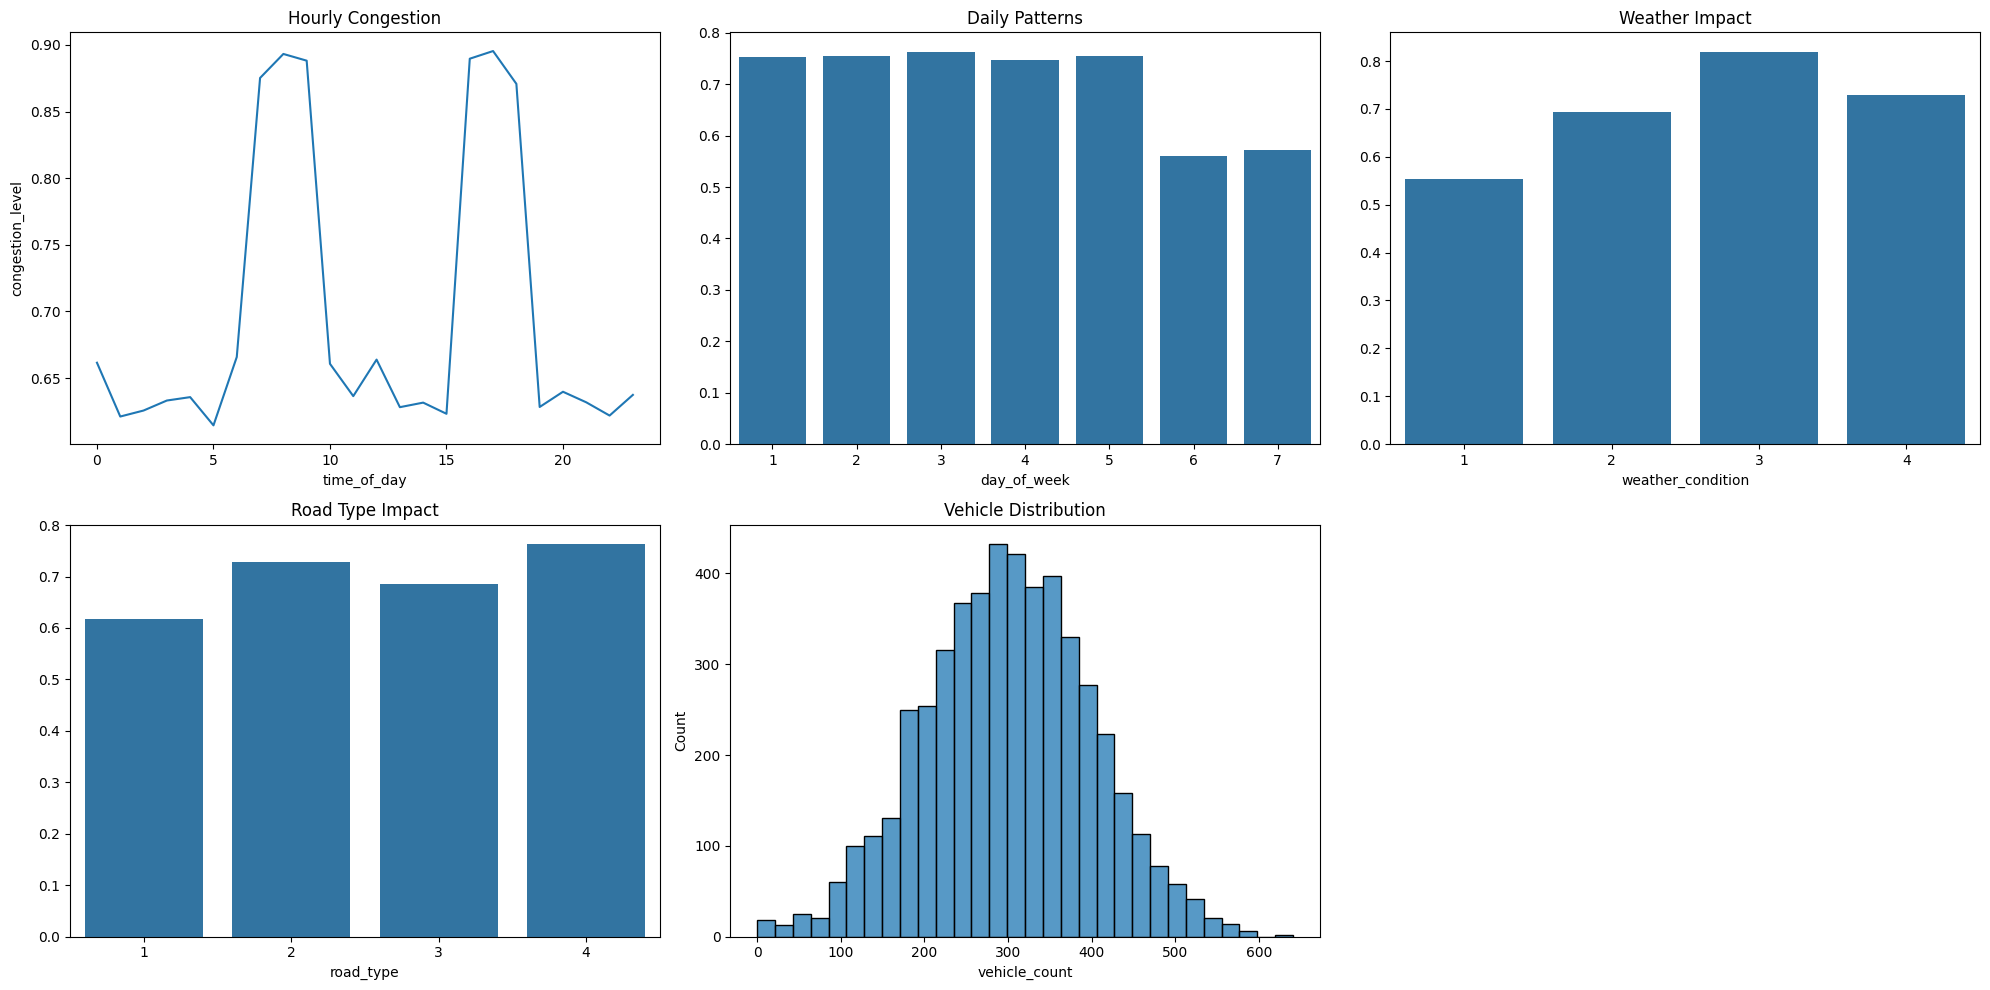

In [3]:
def plot_traffic_patterns(df):
    plt.figure(figsize=(20, 10))
    
    # Hourly analysis
    plt.subplot(231)
    hourly = df.groupby('time_of_day')['congestion_level'].mean()
    sns.lineplot(data=hourly)
    plt.title('Hourly Congestion')
    
    # Daily analysis  
    plt.subplot(232)
    daily = df.groupby('day_of_week')['congestion_level'].mean()
    sns.barplot(x=daily.index, y=daily.values)
    plt.title('Daily Patterns')
    
    # Weather impact
    plt.subplot(233)
    weather = df.groupby('weather_condition')['congestion_level'].mean()
    sns.barplot(x=weather.index, y=weather.values)
    plt.title('Weather Impact')
    
    # Road analysis
    plt.subplot(234)
    road = df.groupby('road_type')['congestion_level'].mean()
    sns.barplot(x=road.index, y=road.values)
    plt.title('Road Type Impact')
    
    # Vehicle distribution
    plt.subplot(235)
    sns.histplot(data=df, x='vehicle_count', bins=30)
    plt.title('Vehicle Distribution')
    
    plt.tight_layout()
    plt.show()

plot_traffic_patterns(df)

## 4. Add model training:


R² Score: 0.8777
MSE: 0.0055
MAE: 0.0582


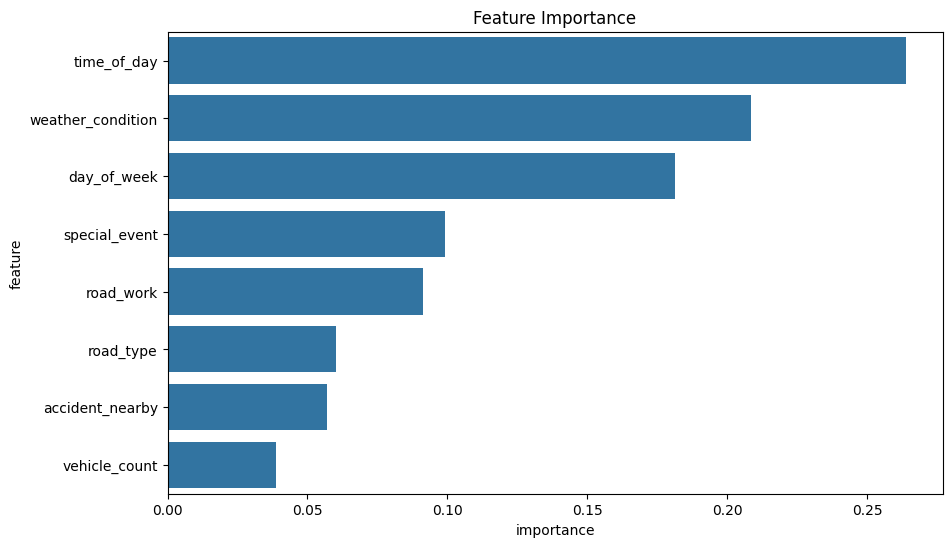

In [4]:
# Prepare data
X = df.drop('congestion_level', axis=1)
y = df['congestion_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()